# 1. Data Cleaning

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from scipy.stats import pearsonr
from statsmodels.tsa.stattools import adfuller
%matplotlib inline

/Users/harshitsrivastava/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### 1.1 Reading Data and removing Null Values

In [70]:
# Importing the Terrorism Database and removing all the unnecessary columns
terrorism = pd.read_csv('globalterrorismdb_0617dist.csv', encoding='ISO-8859-1',
                          usecols=[0, 1, 2, 3, 8, 11, 13, 14, 37, 82, 98, 101])

# Renaming some of the columns for ease of use
terrorism = terrorism.rename(
    columns={'eventid':'id', 'iyear':'year', 'imonth':'month', 'iday':'day',
             'country_txt':'country', 'provstate':'state', 'targsubtype1_txt':'target',
             'weaptype1_txt':'weapon', 'nkill':'fatalities', 'nwound':'injuries'})

# Filling Null values with 0
terrorism['fatalities'] = terrorism['fatalities'].fillna(0).astype(int)
terrorism['injuries'] = terrorism['injuries'].fillna(0).astype(int)

In [71]:
for col in terrorism:
    print col

id
year
month
day
country
state
latitude
longitude
target
weapon
fatalities
injuries


In [72]:
terrorism.head()

,id,year,month,day,country,state,latitude,longitude,target,weapon,fatalities,injuries
0,197000000001,1970,7,2,Dominican Republic,NaN,18.456792,-69.951164,Named Civilian,Unknown,1,0
1,197000000002,1970,0,0,Mexico,NaN,19.432608,-99.133207,"Diplomatic Personnel (outside of embassy, cons...",Unknown,0,0
2,197001000001,1970,1,0,Philippines,Tarlac,15.478598,120.599741,Radio Journalist/Staff/Facility,Unknown,1,0
3,197001000002,1970,1,0,Greece,Attica,37.983773,23.728157,Embassy/Consulate,Explosives/Bombs/Dynamite,0,0
4,197001000003,1970,1,0,Japan,NaN,33.580412,130.396361,Embassy/Consulate,Incendiary,0,0


### 1.2 Selecting the attacks which happened in Pakistan and after 2004

In [76]:
# terrorist attacks in Pakistan only (11, 640 rows)
terror_pakistan = terrorism[(terrorism.country == 'Pakistan') &
                         (terrorism.year > 2003)]

# Filling the Invalid Column values
terror_pakistan['day'][terror_pakistan.day == 0] = 1
terror_pakistan['month'][terror_pakistan.day == 0] = 1

# Converting the Year, Month and Day column to Date-Time object
terror_pakistan['Date'] = np.nan
terror_pakistan['Date'] = pd.to_datetime((terror_pakistan.year*10000+terror_pakistan.month*100+terror_pakistan.day).apply(str),format='%Y%m%d')

/Users/harshitsrivastava/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/harshitsrivastava/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/Users/harshitsrivastava/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD f

### 1.3 Creating new DataFrame of every day

This new DataFrame will represent every day from 2004 to 2018 by a single row. The days on which Terrorist attack in Pakistan took place, will have the corresponding statistics of the attack. Rest all rows will have 0.

In [ ]:
import datetime
#data

#datadate['year'] = np.arange(2004,2018)
start_date = datetime.date(2004,1,1)
end_date= datetime.date(2017,12,31)
#help(datetime)
days = pd.date_range(start_date, end_date)
terrordate = pd.DataFrame(index=days)
terrordate.index.name='Date'
terrordate['fatalities'] = np.nan
terrordate['injuries'] = np.nan
for i in range(0, len(terrordate.fatalities)):
    terrordate['Month']=days.strftime("%B")
    terrordate['Year']=days.year

ind_list = terror_pakistan.index.values

for i in ind_list:
    if(terror_pakistan['Date'][i] in terrordate.index):
        
        terrordate['fatalities'][terror_pakistan['Date'][i]] = terror_pakistan['fatalities'][i]
        terrordate['injuries'][terror_pakistan['Date'][i]] = terror_pakistan['injuries'][i]
        
terrordate['Strike'] = np.nan

for i in range(0, len(terrordate.fatalities)):
    if np.isnan(terrordate.fatalities[i]) == False:
        terrordate.Strike[i] = 1

terrordate = terrordate.fillna(0)

### 1.4 Importing the Drone-Attack Data

In [104]:
%store -r datadate

# 2. Exploratory Data Analysis

### 2.1 Visualizing Text Data

/Users/harshitsrivastava/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


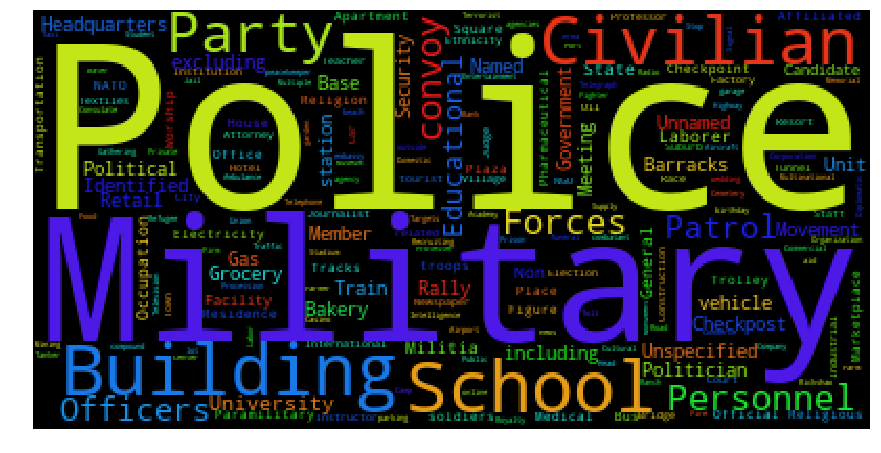

In [7]:
# Using Wordcloud library to visualize the high-frequency words (https://github.com/amueller/word_cloud)
from wordcloud import WordCloud

# Creating empty list and a list containing Index of the Terrorism in Pakistan Database
b=[]
ind_list = terror_pakistan.index

# Iterating over the values and removing the bad values
for i in ind_list:
    try:
        terror_pakistan['target'][i]=str(terror_pakistan['target'][i])
    except UnicodeEncodeError:
        continue
        
    # Ignoring the Null Values
    if (terror_pakistan['target'][i]!=np.nan):
        b.append(terror_pakistan['target'][i])
        
b = [x for x in b if str(x) != 'nan']

# Generating the picture using WordCloud 
wordcloud = WordCloud().generate(' '.join(b))

# Plotting the image generated
plt.figure(figsize=(14, 10))
plt.imshow(wordcloud)
plt.axis("off")
#print a
plt.show()

This image represents the frequency of every 'Target' of a Terrorist Attack. Highest frequency words 'Police' and 'Military' implies that the main enimies of the Terrorists is the Security Forces. Most of the Terrorist Attacks are known to be carried out in retaliation of the Security Forces which are trying to supress them. Additionally, there are also words like 'Civilians' and 'School' which represent the threat and pain that the whole world is now wary of.

### 2.2 Visualizing the Time-Series Data

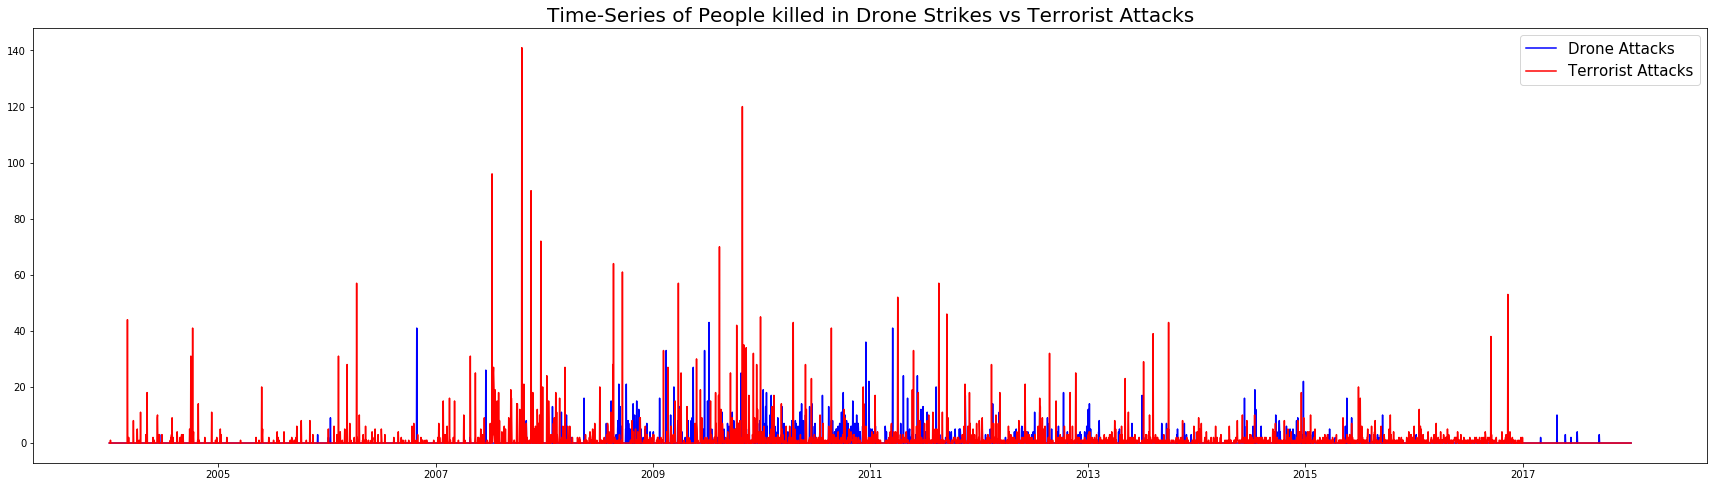

In [106]:
plt.figure(figsize=(30,8))
plt.plot(datadate['Deaths'],color='blue', label = 'Drone Attacks')
plt.plot(terrordate['fatalities'],color='Red', label = 'Terrorist Attacks')
plt.title('Time-Series of People killed in Drone Strikes vs Terrorist Attacks', fontsize = 20)
plt.legend(fontsize = 15)
plt.show()

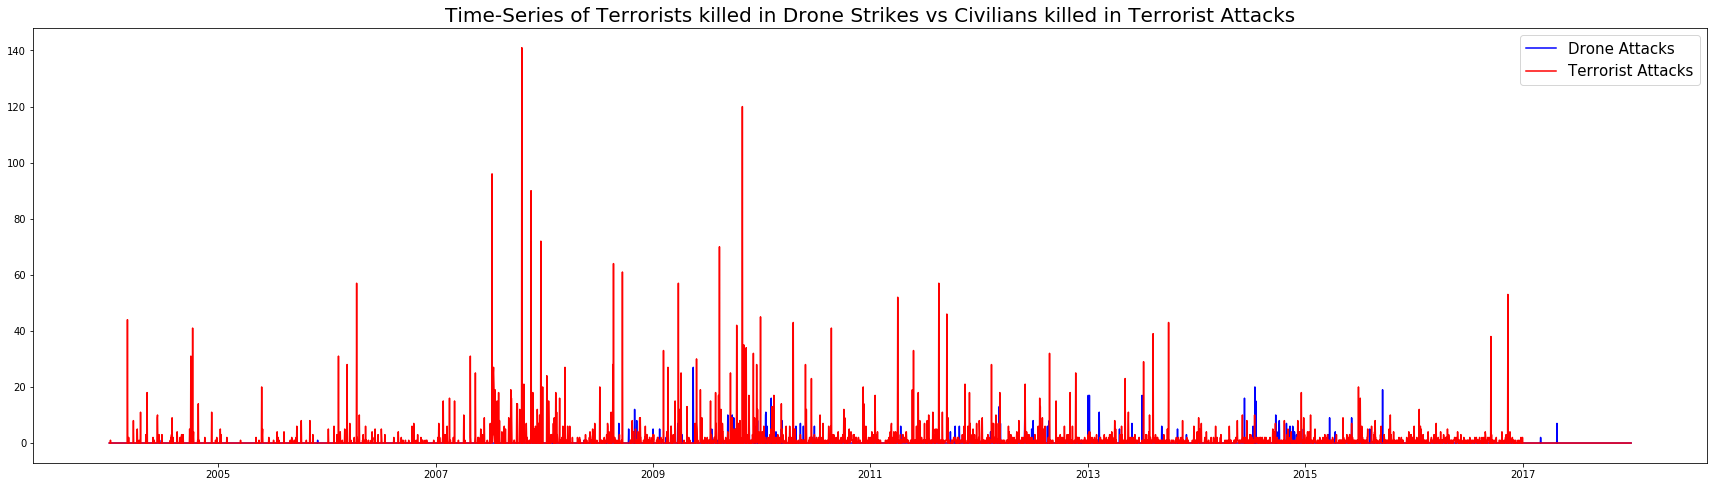

In [107]:
plt.figure(figsize=(30,8))
plt.plot(datadate['Terrorists'],color='blue', label = 'Drone Attacks')
plt.plot(terrordate['fatalities'],color='Red', label = 'Terrorist Attacks')
plt.title('Time-Series of Terrorists killed in Drone Strikes vs Civilians killed in Terrorist Attacks', fontsize = 20)
plt.legend(fontsize = 15)

In [77]:
terror_pakistan.head()

,id,year,month,day,country,state,latitude,longitude,target,weapon,fatalities,injuries,Date
76089,200401050002,2004,1,5,Pakistan,Punjab,30.292088,71.931244,Religious Figure,Firearms,1,0,2004-01-05
76126,200401150001,2004,1,15,Pakistan,Sindh,24.893379,67.028061,Affiliated Institution,Explosives/Bombs/Dynamite,0,15,2004-01-15
76181,200402160007,2004,2,16,Pakistan,Gilgit-Baltistan,35.918091,74.289803,Place of Worship,Explosives/Bombs/Dynamite,0,5,2004-02-16
76207,200403020004,2004,3,2,Pakistan,Balochistan,30.182125,67.000517,Religion Identified,Firearms,44,130,2004-03-02
76221,200403060003,2004,3,6,Pakistan,Sindh,24.893379,67.028061,Party Official/Candidate/Other Personnel,Firearms,2,0,2004-03-06


# 3. Analyzing the relationship between Drone Attacks and Terrorist Attacks

## 3.1 Checking for Lagged Correlation between 2 Time-Series

### 3.1.1 Performing ADF Test to check for stationarity in Time-Series

In [10]:
# Augmented Dickey Fuller Test of Terrorism Time-Series to check stationarity

#Perform Dickey-Fuller test:
print 'Results of Dickey-Fuller Test:'
dftest = adfuller(terrordate['Strike'], autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print dfoutput

Results of Dickey-Fuller Test:
Test Statistic                   -3.024782
p-value                           0.032644
#Lags Used                       30.000000
Number of Observations Used    5083.000000
Critical Value (5%)              -2.862109
Critical Value (1%)              -3.431637
Critical Value (10%)             -2.567073
dtype: float64


The Test Statistic shows that there is more than 95% confidence that the Terrorism Time-Series is stationary

In [96]:
# Augmented Dickey Fuller Test of Drone Attack Time-Series to check stationarity

#Perform Dickey-Fuller test:
print 'Results of Dickey-Fuller Test:'
dftest = adfuller(datadate['Strikes'], autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print dfoutput

Results of Dickey-Fuller Test:
Test Statistic                -7.725585e+00
p-value                        1.161418e-11
#Lags Used                     3.300000e+01
Number of Observations Used    5.080000e+03
Critical Value (5%)           -2.862109e+00
Critical Value (1%)           -3.431638e+00
Critical Value (10%)          -2.567073e+00
dtype: float64


The Test Statistic shows that there is more than 99% confidence that the Drone Attack Time-Series is stationary

### 3.1.2 Performing SpearmanR Test to check for correlation

In [97]:
terr = terrordate['fatalities'][1:].values
drone = datadate['Strikes'][:-1].values

corr, pvalue = spearmanr(terr, drone)
print "Sample Size:\t\t\t\t\t\t", len(terr)
print "Correlation between the 2 Time-Series at Lag = 1 Day:\t", corr
print "Probability that 2 Time-Series are NOT connected:\t", pvalue

Sample Size:						5113
Correlation between the 2 Time-Series at Lag = 1 Day:	0.0476873074759
Probability that 2 Time-Series are NOT connected:	0.000647252346417


SpearmanR Test is based on the Null Hypothesis that the 2 datasets are not correlated. The p-value gives the confidence score of the Hypothesis. P-Value < 0.05 means that we can safely reject the Null Hypothesis and thereby claim that the 2 Time-Series are in fact correlated with a lag of 1 day

## 3.2 Analysis on a Daily Basis

Next we analyze the Attacks on a Daily Basis. We filter out the days in which Drone Strikes took place and then calculated the days after which a Terrorist Attack took place. We then store it in a new column of the filtered data

In [100]:
fil_drone = datadate[(datadate['Strikes'] > 0 )]        # Filtering the data of all the days in which there was a
                                                        # Drone-Attack

# Creating list of Index of Drone Attacks Time-Series
ind = fil_drone.index

# Creating a new column to store Number of Days after which a Terrorist Attack took place
fil_drone['terror_strikes'] = np.nan

for i in ind:
    # Initializing Start Date to iterate over
    start_date = i
    
    for j in range(0, 100):
        # Using timedelta() function through which we can add days to a Date-time object
        if terrordate.loc[start_date + datetime.timedelta(days=j)].Strike != 0 :
            fil_drone['terror_strikes'][i] = j
            break
        else:
            continue

/Users/harshitsrivastava/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/harshitsrivastava/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [103]:
fil_drone.head()

,Terrorists,Civilians,Injured,Foreigners,Month,Year,Strikes,terror_strikes
Date,,,,,,,,
2004-06-18,1.0,2.0,0.0,0.0,June,2004,1.0,2.0
2005-05-08,1.0,1.0,0.0,0.0,May,2005,1.0,0.0
2005-12-01,1.0,1.0,1.0,2.0,December,2005,1.0,5.0
2006-01-06,0.0,0.0,1.0,0.0,January,2006,1.0,0.0
2006-01-13,0.0,9.0,1.0,0.0,January,2006,1.0,5.0


### 3.2.1 Plotting the Number of Days 

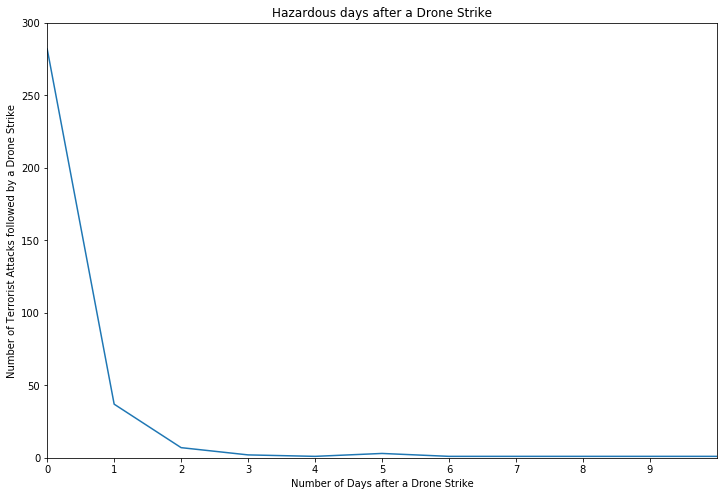

In [102]:
days = fil_drone.groupby(['terror_strikes']).size()

plt.figure(figsize=(12, 8))
plt.xticks(range(0, 10))
plt.xlim(0, 10)
plt.ylim(0, 300)
plt.title('Hazardous days after a Drone Strike')
plt.plot(days)
plt.ylabel('Number of Terrorist Attacks followed by a Drone Strike')
plt.xlabel('Number of Days after a Drone Strike')

In [68]:
days

terror_strikes
0.0     282
1.0      37
2.0       7
3.0       2
4.0       1
5.0       3
6.0       1
8.0       1
14.0      1
16.0      1
dtype: int64

From the above plot and figure, we can see that there have been a significantly high number of Terrorist Attacks on the Day when Drone Strike took place and also in the day following the Drone Strike. This trend gradually goes down to 0 after a few days. The plot perfectly represents the Danger of more Terror and disruption after a Drone Strike.